# **Fraud Analysis**

## **Inicialização**

Importa as bibliotecas necessárias para o desenvolvimento do projeto

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Configurações iniciais

In [ ]:
SEED = 13

## **Base de Dados**

Importa a base de dados com as transações de cartão de crédito

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_url = '/content/drive/MyDrive/Fraud Analysis/creditcard.csv'
dataset = pd.read_csv(dataset_url)

Mostra a base de dados de cartão de crédito

In [ ]:
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Mostra distribuição de dados para cada classe

In [ ]:
dataset.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Estatísticas da base de dados

In [ ]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

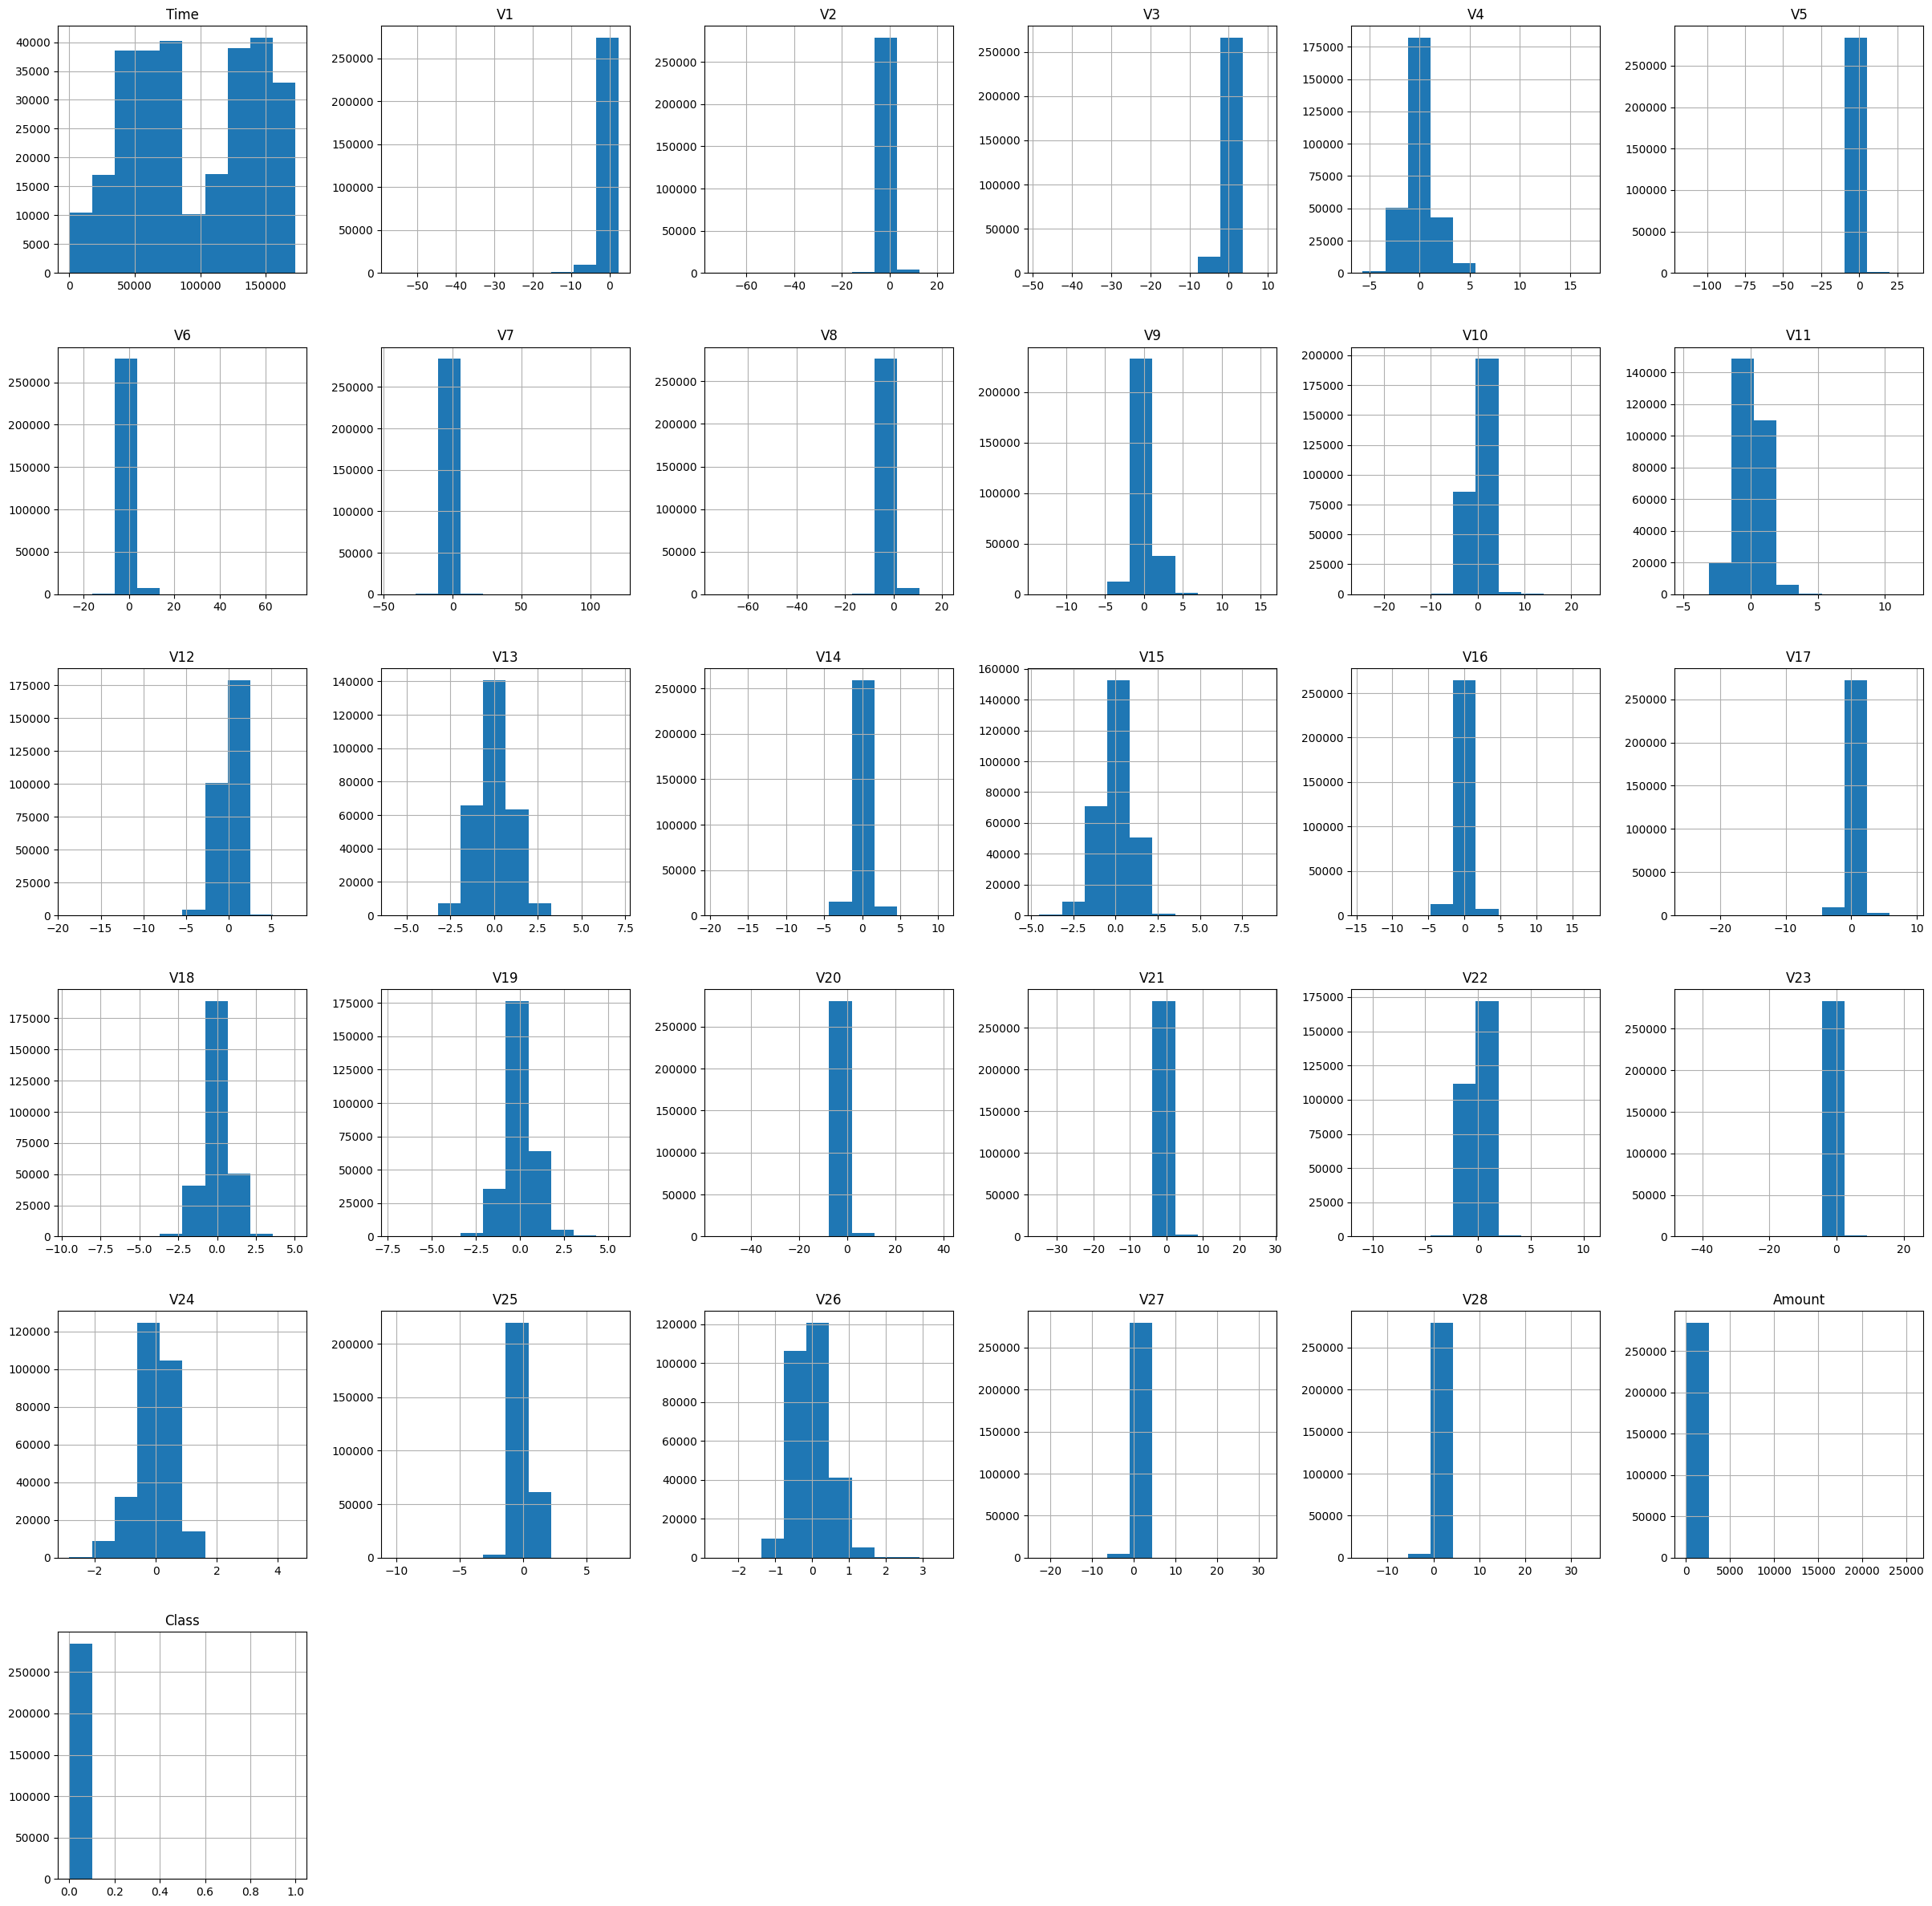

In [ ]:
dataset.hist(figsize = (30, 30))

## **Divisão de datasets**

Divide base de dados em base de treino, validação e teste

In [ ]:
x_train, x_test = train_test_split(dataset, test_size = 0.3, random_state = SEED, shuffle = True, stratify = dataset.Class)
x_val, x_test = train_test_split(x_test, test_size = 0.33, random_state = SEED, shuffle = True, stratify = x_test.Class)

Mostra divisão de classes em cada conjunto de dataset

In [ ]:
x_train.Class.value_counts()

0    199020
1       344
Name: Class, dtype: int64

In [ ]:
x_val.Class.value_counts()

0    57147
1       99
Name: Class, dtype: int64

In [ ]:
x_test.Class.value_counts()

0    28148
1       49
Name: Class, dtype: int64

In [ ]:
dataset_test = x_test

In [ ]:
y_train = x_train['Class']
y_train.to_numpy()
x_train = x_train.drop('Class', axis = 1)
x_train.to_numpy()

y_val = x_val['Class']
y_val.to_numpy()
x_val = x_val.drop('Class', axis = 1)
x_val.to_numpy()

y_test = x_test['Class']
y_test.to_numpy()
x_test = x_test.drop('Class', axis = 1)
x_test.to_numpy()

array([[ 1.53576000e+05,  1.95001266e+00,  1.23161097e-01, ...,
        -6.57858140e-04, -4.94415033e-02,  2.44000000e+01],
       [ 1.53770000e+05,  1.75399321e+00, -8.33654304e-01, ...,
         2.83927847e-02, -1.40758221e-02,  1.57500000e+02],
       [ 1.19155000e+05,  2.05041588e+00, -1.13276239e-01, ...,
        -2.37498876e-02, -7.21348346e-02,  1.00000000e+00],
       ...,
       [ 8.55420000e+04, -6.24619563e-01,  1.26254926e+00, ...,
         3.68605493e-01,  1.56912227e-01,  1.79000000e+00],
       [ 1.44373000e+05,  1.79059628e-01,  1.03005515e+00, ...,
         2.23869047e-01,  7.89938952e-02,  1.79000000e+00],
       [ 1.41341000e+05, -1.06591823e+00,  6.18582146e-01, ...,
         2.59788758e-01,  4.72853608e-01,  1.14000000e+02]])

## **Modelos de Classificação**

 Aplicação de modelos de classificação sem técnicas de tratamento de dados

### **Regressão Logistíca**

In [ ]:
logistic_model = LogisticRegression(random_state = SEED)
logistic_model.fit(x_train, y_train)
logistic_accuracy = logistic_model.score(x_val, y_val)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print('Logistic Regression Accuracy: ', logistic_accuracy)

Logistic Regression Accuracy:  0.9988296125493484


In [ ]:
print(classification_report_imbalanced(y_test, logistic_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.76      1.00      0.87      0.77     28148
     Fraude       0.73      0.76      1.00      0.74      0.87      0.74        49

avg / total       1.00      1.00      0.76      1.00      0.87      0.77     28197



### **Random Forest**

In [ ]:
rf_model = RandomForestClassifier(max_depth = 10, random_state = SEED)
rf_model.fit(x_train, y_train)
rf_accuracy = rf_model.score(x_val, y_val)

In [ ]:
print('Random Forest Accuracy: ', rf_accuracy)

Random Forest Accuracy:  0.9993187296929044


In [ ]:
rf_model.score(x_train, y_train),rf_model.score(x_val, y_val)

(0.9997592343652816, 0.9993187296929044)

In [ ]:
print(classification_report_imbalanced(y_test, rf_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.78      1.00      0.88      0.79     28148
     Fraude       0.97      0.78      1.00      0.86      0.88      0.76        49

avg / total       1.00      1.00      0.78      1.00      0.88      0.79     28197



In [ ]:
def create_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = 'right')
  plt.ylabel('Transação')
  plt.xlabel('Predição');

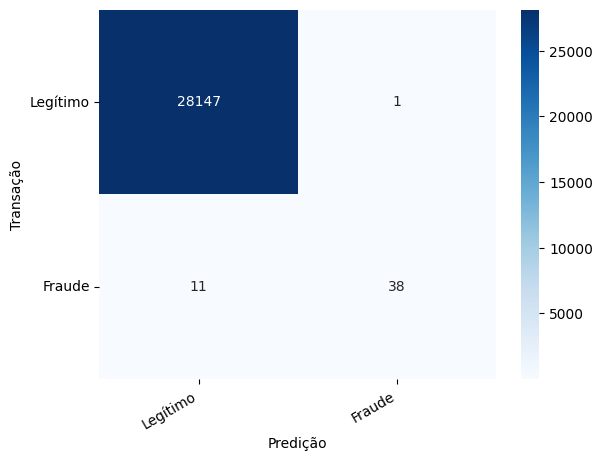

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, rf_model.predict(x_test))
df_cm = pd.DataFrame(cm, index = ["Legítimo", "Fraude"], columns = ["Legítimo", "Fraude"])

create_confusion_matrix(df_cm)

### **SVM**

In [ ]:
svm_model = svm.SVC(kernel = 'linear', random_state = SEED)
svm_model.fit(x_train, y_train)
svm_accuracy = svm_model.score(x_val, y_val)

In [ ]:
print('SVM Accuracy: ', svm_accuracy)

SVM Accuracy:  0.9985675855081578


In [ ]:
print(classification_report_imbalanced(y_test, svm_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.27      1.00      0.52      0.28     28148
     Fraude       0.76      0.27      1.00      0.39      0.52      0.25        49

avg / total       1.00      1.00      0.27      1.00      0.52      0.28     28197



### **XGB**

In [ ]:
xgb_model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 5, random_state = SEED)
xgb_model.fit(x_train, y_train)
xgb_accuracy = xgb_model.score(x_val, y_val)

In [ ]:
print('XGB Accuracy: ', xgb_accuracy)

XGB Accuracy:  0.9984103692834434


In [ ]:
print(classification_report_imbalanced(y_test, xgb_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.18      1.00      0.43      0.20     28148
     Fraude       0.82      0.18      1.00      0.30      0.43      0.17        49

avg / total       1.00      1.00      0.19      1.00      0.43      0.20     28197



### **Rede Neural**

In [ ]:
nn_model = MLPClassifier(hidden_layer_sizes=(100,), random_state = SEED)
nn_model.fit(x_train, y_train)
nn_accuracy = nn_model.score(x_val, y_val)

In [ ]:
print('Neural Network Accuracy: ', nn_accuracy)

Neural Network Accuracy:  0.9982706215281417


In [ ]:
print(classification_report_imbalanced(y_test, nn_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.02      1.00      0.14      0.02     28148
     Fraude       0.25      0.02      1.00      0.04      0.14      0.02        49

avg / total       1.00      1.00      0.02      1.00      0.14      0.02     28197



### **KNN**

In [ ]:
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_val_normalized = scaler.transform(x_val)
x_test_normalized = scaler.transform(x_test)

In [ ]:
k_values = [i for i in range(1,6)]
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    accuracy = cross_val_score(knn, x_train_normalized, y_train, cv = 5)
    accuracies.append(np.mean(accuracy))

Text(0, 0.5, 'Accuracy Score')

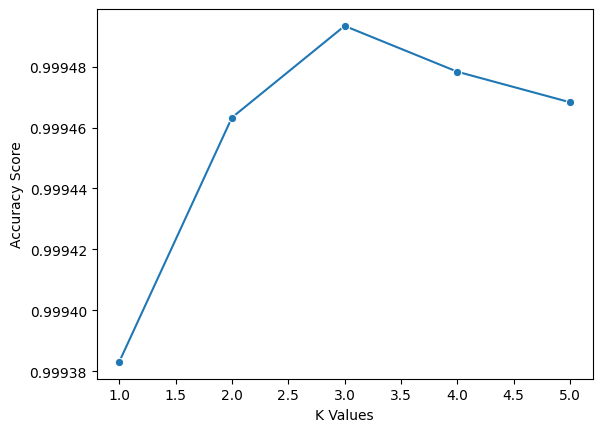

In [ ]:
sns.lineplot(x = k_values, y = accuracies, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
best_index = np.argmax(accuracies)
best_k = k_values[best_index]

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = best_k)
knn_model.fit(x_train_normalized, y_train)
knn_accuracy = cross_val_score(knn_model, x_val_normalized, y_val, cv = 5)

In [ ]:
print('KNN Accuracy: ', np.mean(knn_accuracy))

KNN Accuracy:  0.9991789828519948


In [ ]:
print(classification_report_imbalanced(y_test, knn_model.predict(x_test_normalized), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.76      1.00      0.87      0.77     28148
     Fraude       0.95      0.76      1.00      0.84      0.87      0.74        49

avg / total       1.00      1.00      0.76      1.00      0.87      0.77     28197



### **Oversampling**

In [ ]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

#### **Random**

In [ ]:
ros = RandomOverSampler(random_state = SEED)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
x_train_ros_normalized, y_train_ros_normalized = ros.fit_resample(x_train_normalized, y_train)

In [ ]:
y_train_ros.value_counts()

0    199020
1    199020
Name: Class, dtype: int64

#### **SMOTE**

In [ ]:
smote = SMOTE(random_state = SEED)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
x_train_smote_normalized, y_train_smote_normalized = ros.fit_resample(x_train_normalized, y_train)

In [ ]:
y_train_smote.value_counts()

0    199020
1    199020
Name: Class, dtype: int64

#### **ADASYN**

In [ ]:
adasyn = ADASYN(random_state = SEED)
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)
x_train_adasyn_normalized, y_train_adasyn_normalized = ros.fit_resample(x_train_normalized, y_train)

In [ ]:
y_train_adasyn.value_counts()

1    199099
0    199020
Name: Class, dtype: int64

 Aplicação de modelos de classificação utilizando a técnica de oversampling

#### **Regressão Logistíca**

In [ ]:
ros_logistic_model = LogisticRegression(random_state = SEED)
ros_logistic_model.fit(x_train_ros, y_train_ros)
ros_logistic_accuracy = ros_logistic_model.score(x_val, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('Logistic Regression Accuracy: ', ros_logistic_accuracy)

Logistic Regression Accuracy:  0.972888935471474


In [ ]:
print(classification_report_imbalanced(y_test, ros_logistic_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.97      0.90      0.99      0.93      0.88     28148
     Fraude       0.06      0.90      0.97      0.11      0.93      0.87        49

avg / total       1.00      0.97      0.90      0.98      0.93      0.88     28197



In [ ]:
smote_logistic_model = LogisticRegression(random_state = SEED)
smote_logistic_model.fit(x_train_smote, y_train_smote)
smote_logistic_accuracy = smote_logistic_model.score(x_val, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('Logistic Regression Accuracy: ', smote_logistic_accuracy)

Logistic Regression Accuracy:  0.9823743143625755


In [ ]:
print(classification_report_imbalanced(y_test, smote_logistic_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.98      0.90      0.99      0.94      0.89     28148
     Fraude       0.09      0.90      0.98      0.16      0.94      0.88        49

avg / total       1.00      0.98      0.90      0.99      0.94      0.89     28197



In [ ]:
adasyn_logistic_model = LogisticRegression(random_state = SEED)
adasyn_logistic_model.fit(x_train_adasyn, y_train_adasyn)
adasyn_logistic_accuracy = adasyn_logistic_model.score(x_val, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('Logistic Regression Accuracy: ', adasyn_logistic_accuracy)

Logistic Regression Accuracy:  0.9766097194563812


In [ ]:
print(classification_report_imbalanced(y_test, adasyn_logistic_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.98      0.90      0.99      0.94      0.89     28148
     Fraude       0.07      0.90      0.98      0.12      0.94      0.87        49

avg / total       1.00      0.98      0.90      0.99      0.94      0.89     28197



#### **Random Forest**

In [ ]:
ros_rf_model = RandomForestClassifier(class_weight = "balanced_subsample", oob_score = True, bootstrap = True, max_depth = 15, random_state = SEED)
ros_rf_model.fit(x_train_ros, y_train_ros)
ros_rf_accuracy = ros_rf_model.score(x_val, y_val)

In [ ]:
print('Random Forest Accuracy: ', ros_rf_accuracy)

Random Forest Accuracy:  0.999336198162317


In [ ]:
print(classification_report_imbalanced(y_test, ros_rf_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.78      1.00      0.88      0.79     28148
     Fraude       0.90      0.78      1.00      0.84      0.88      0.76        49

avg / total       1.00      1.00      0.78      1.00      0.88      0.79     28197



In [ ]:
ros_rf_model.score(x_train, y_train),ros_rf_model.oob_score_,ros_rf_model.score(x_val, y_val)

(0.9998796171826408, 0.9998969952768566, 0.999336198162317)

In [ ]:
smote_rf_model = RandomForestClassifier(max_depth = 10, random_state = SEED)
smote_rf_model.fit(x_train_smote, y_train_smote)
smote_rf_accuracy = smote_rf_model.score(x_val, y_val)

In [ ]:
print('Random Forest Accuracy: ', smote_rf_accuracy)

Random Forest Accuracy:  0.998672396324634


In [ ]:
print(classification_report_imbalanced(y_test, smote_rf_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.86      1.00      0.93      0.87     28148
     Fraude       0.71      0.86      1.00      0.78      0.93      0.84        49

avg / total       1.00      1.00      0.86      1.00      0.93      0.87     28197



In [ ]:
adasyn_rf_model = RandomForestClassifier(max_depth = 10, random_state = SEED)
adasyn_rf_model.fit(x_train_adasyn, y_train_adasyn)
adasyn_rf_accuracy = adasyn_rf_model.score(x_val, y_val)

In [ ]:
print('Random Forest Accuracy: ', adasyn_rf_accuracy)

Random Forest Accuracy:  0.9986199909163959


In [ ]:
print(classification_report_imbalanced(y_test, adasyn_rf_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.86      1.00      0.93      0.87     28148
     Fraude       0.67      0.86      1.00      0.75      0.93      0.84        49

avg / total       1.00      1.00      0.86      1.00      0.93      0.87     28197



#### **KNN**

In [ ]:
ros_knn_model = KNeighborsClassifier(n_neighbors = best_k)
ros_knn_model.fit(x_train_ros_normalized, y_train_ros_normalized)
ros_knn_accuracy = cross_val_score(ros_knn_model, x_val_normalized, y_val, cv = 5)

In [ ]:
print('KNN Accuracy: ', np.mean(ros_knn_accuracy))

KNN Accuracy:  0.9991789828519948


In [ ]:
print(classification_report_imbalanced(y_test, ros_knn_model.predict(x_test_normalized), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.82      1.00      0.90      0.83     28148
     Fraude       0.77      0.82      1.00      0.79      0.90      0.80        49

avg / total       1.00      1.00      0.82      1.00      0.90      0.83     28197



In [ ]:
smote_knn_model = KNeighborsClassifier(n_neighbors = best_k)
smote_knn_model.fit(x_train_smote_normalized, y_train_smote_normalized)
smote_knn_accuracy = cross_val_score(smote_knn_model, x_val_normalized, y_val, cv = 5)

In [ ]:
print('KNN Accuracy: ', np.mean(smote_knn_accuracy))

KNN Accuracy:  0.9991789828519948


In [ ]:
print(classification_report_imbalanced(y_test, smote_knn_model.predict(x_test_normalized), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.82      1.00      0.90      0.83     28148
     Fraude       0.77      0.82      1.00      0.79      0.90      0.80        49

avg / total       1.00      1.00      0.82      1.00      0.90      0.83     28197



In [ ]:
adasyn_knn_model = KNeighborsClassifier(n_neighbors = best_k)
adasyn_knn_model.fit(x_train_adasyn_normalized, y_train_adasyn_normalized)
adasyn_knn_accuracy = cross_val_score(adasyn_knn_model, x_val_normalized, y_val, cv = 5)

In [ ]:
print('KNN Accuracy: ', np.mean(adasyn_knn_accuracy))

KNN Accuracy:  0.9991789828519948


In [ ]:
print(classification_report_imbalanced(y_test, adasyn_knn_model.predict(x_test_normalized), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.82      1.00      0.90      0.83     28148
     Fraude       0.77      0.82      1.00      0.79      0.90      0.80        49

avg / total       1.00      1.00      0.82      1.00      0.90      0.83     28197



#### **Rede Neural**

In [ ]:
ros_nn_model = MLPClassifier(hidden_layer_sizes=(100,), random_state = SEED)
ros_nn_model.fit(x_train_ros, y_train_ros)
ros_nn_accuracy = ros_nn_model.score(x_val, y_val)

In [ ]:
print('Neural Network Accuracy: ', ros_nn_accuracy)

Neural Network Accuracy:  0.9812039269119239


In [ ]:
print(classification_report_imbalanced(y_test, ros_nn_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.98      0.88      0.99      0.93      0.87     28148
     Fraude       0.08      0.88      0.98      0.14      0.93      0.85        49

avg / total       1.00      0.98      0.88      0.99      0.93      0.87     28197



#### **XGB**

In [ ]:
smote_xgb_model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 5, random_state = SEED)
smote_xgb_model.fit(x_train_smote, y_train_smote)
smote_xgb_accuracy = smote_xgb_model.score(x_val, y_val)

In [ ]:
print('XGB Accuracy: ', smote_xgb_accuracy)

XGB Accuracy:  0.9985675855081578


In [ ]:
print(classification_report_imbalanced(y_test, smote_xgb_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      1.00      0.78      1.00      0.88      0.79     28148
     Fraude       0.53      0.78      1.00      0.63      0.88      0.76        49

avg / total       1.00      1.00      0.78      1.00      0.88      0.79     28197



#### **SVM**

In [ ]:
smote_svm_model = svm.SVC(kernel = 'linear', random_state = SEED)
smote_svm_model.fit(x_train_smote, y_train_smote)
smote_svm_accuracy = smote_svm_model.score(x_val, y_val)

In [ ]:
print('SVM Accuracy: ', smote_svm_accuracy)

In [ ]:
print(classification_report_imbalanced(y_test, smote_svm_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

### **Undersampling**

In [ ]:
y_train.value_counts()

0    199020
1       344
Name: Class, dtype: int64

#### **Random Undersampling**

In [ ]:
rus = RandomUnderSampler(random_state = SEED)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
x_train_rus_normalized, y_train_rus_normalized = rus.fit_resample(x_train_normalized, y_train)

In [ ]:
y_train_rus.value_counts()

0    344
1    344
Name: Class, dtype: int64

#### **Near Miss**

In [ ]:
nm = NearMiss()
x_train_nm, y_train_nm = nm.fit_resample(x_train, y_train)
x_train_nm_normalized, y_train_nm_normalized = nm.fit_resample(x_train_normalized, y_train)

In [ ]:
y_train_nm.value_counts()

0    344
1    344
Name: Class, dtype: int64

#### **Regressão Logistíca**

In [ ]:
rus_logistic_model = LogisticRegression(random_state = SEED)
rus_logistic_model.fit(x_train_rus, y_train_rus)
rus_logistic_accuracy = rus_logistic_model.score(x_val, y_val)

In [ ]:
print('Logistic Regression Accuracy: ', rus_logistic_accuracy)

Logistic Regression Accuracy:  0.9569926283059078


In [ ]:
print(classification_report_imbalanced(y_test, rus_logistic_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.96      0.88      0.98      0.92      0.85     28148
     Fraude       0.03      0.88      0.96      0.07      0.92      0.83        49

avg / total       1.00      0.96      0.88      0.98      0.92      0.85     28197



In [ ]:
nm_logistic_model = LogisticRegression(random_state = SEED)
nm_logistic_model.fit(x_train_nm, y_train_nm)
nm_logistic_accuracy = nm_logistic_model.score(x_val, y_val)

In [ ]:
print('Logistic Regression Accuracy: ', nm_logistic_accuracy)

Logistic Regression Accuracy:  0.762079446598889


In [ ]:
print(classification_report_imbalanced(y_test, nm_logistic_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.76      0.92      0.86      0.84      0.69     28148
     Fraude       0.01      0.92      0.76      0.01      0.84      0.71        49

avg / total       1.00      0.76      0.92      0.86      0.84      0.69     28197



#### **Random Forest**

In [ ]:
rus_rf_model = RandomForestClassifier(max_depth = 10, random_state = SEED)
rus_rf_model.fit(x_train_rus, y_train_rus)
rus_rf_accuracy = rus_rf_model.score(x_val, y_val)

In [ ]:
print('Random Forest Accuracy: ', rus_rf_accuracy)

Random Forest Accuracy:  0.9853788911015616


In [ ]:
print(classification_report_imbalanced(y_test, rus_rf_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.99      0.86      0.99      0.92      0.86     28148
     Fraude       0.10      0.86      0.99      0.18      0.92      0.83        49

avg / total       1.00      0.99      0.86      0.99      0.92      0.86     28197



In [ ]:
nm_rf_model = RandomForestClassifier(max_depth = 10, random_state = SEED)
nm_rf_model.fit(x_train_nm, y_train_nm)
nm_rf_accuracy = nm_rf_model.score(x_val, y_val)

In [ ]:
print('Random Forest Accuracy: ', nm_rf_accuracy)

Random Forest Accuracy:  0.8353247388463823


In [ ]:
print(classification_report_imbalanced(y_test, nm_rf_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.84      0.90      0.91      0.87      0.75     28148
     Fraude       0.01      0.90      0.84      0.02      0.87      0.76        49

avg / total       1.00      0.84      0.90      0.91      0.87      0.75     28197



#### **KNN**

In [ ]:
rus_knn_model = KNeighborsClassifier(n_neighbors = best_k)
rus_knn_model.fit(x_train_rus_normalized, y_train_rus_normalized)
rus_knn_accuracy = cross_val_score(rus_knn_model, x_val_normalized, y_val, cv = 5)

In [ ]:
print('KNN Accuracy: ', np.mean(rus_knn_accuracy))

KNN Accuracy:  0.9991789828519948


In [ ]:
print(classification_report_imbalanced(y_test, rus_knn_model.predict(x_test_normalized), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.98      0.88      0.99      0.93      0.87     28148
     Fraude       0.07      0.88      0.98      0.13      0.93      0.85        49

avg / total       1.00      0.98      0.88      0.99      0.93      0.87     28197



In [ ]:
nm_knn_model = KNeighborsClassifier(n_neighbors = best_k)
nm_knn_model.fit(x_train_nm_normalized, y_train_nm_normalized)
nm_knn_accuracy = cross_val_score(nm_knn_model, x_val_normalized, y_val, cv = 5)

In [ ]:
print('KNN Accuracy: ', np.mean(nm_knn_accuracy))

KNN Accuracy:  0.9991789828519948


In [ ]:
print(classification_report_imbalanced(y_test, nm_knn_model.predict(x_test_normalized), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.63      0.94      0.77      0.77      0.57     28148
     Fraude       0.00      0.94      0.63      0.01      0.77      0.61        49

avg / total       1.00      0.63      0.94      0.77      0.77      0.57     28197



#### **Rede Neural**

In [ ]:
rus_nn_model = MLPClassifier(hidden_layer_sizes=(100,), random_state = SEED)
rus_nn_model.fit(x_train_rus, y_train_rus)
rus_nn_accuracy = rus_nn_model.score(x_val, y_val)

In [ ]:
print('Neural Network Accuracy: ', rus_nn_accuracy)

Neural Network Accuracy:  0.986741431715753


In [ ]:
print(classification_report_imbalanced(y_test, rus_nn_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.99      0.08      0.99      0.28      0.09     28148
     Fraude       0.01      0.08      0.99      0.02      0.28      0.07        49

avg / total       1.00      0.99      0.08      0.99      0.28      0.09     28197



In [ ]:
nm_nn_model = MLPClassifier(hidden_layer_sizes=(100,), random_state = SEED)
nm_nn_model.fit(x_train_nm, y_train_nm)
nm_nn_accuracy = nm_nn_model.score(x_val, y_val)

In [ ]:
print('Neural Network Accuracy: ', nm_nn_accuracy)

Neural Network Accuracy:  0.9237151940746952


In [ ]:
print(classification_report_imbalanced(y_test, nm_nn_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.93      0.31      0.96      0.53      0.30     28148
     Fraude       0.01      0.31      0.93      0.01      0.53      0.27        49

avg / total       1.00      0.93      0.31      0.96      0.53      0.30     28197



#### **XGB**

In [ ]:
rus_xgb_model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 5, random_state = SEED)
rus_xgb_model.fit(x_train_rus, y_train_rus)
rus_xgb_accuracy = rus_xgb_model.score(x_val, y_val)

In [ ]:
print('XGB Accuracy: ', rus_xgb_accuracy)

XGB Accuracy:  0.9596827725954652


In [ ]:
print(classification_report_imbalanced(y_test, rus_xgb_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.96      0.88      0.98      0.92      0.85     28148
     Fraude       0.04      0.88      0.96      0.07      0.92      0.84        49

avg / total       1.00      0.96      0.88      0.98      0.92      0.85     28197



In [ ]:
nm_xgb_model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 5, random_state = SEED)
nm_xgb_model.fit(x_train_nm, y_train_nm)
nm_xgb_accuracy = nm_xgb_model.score(x_val, y_val)

In [ ]:
print('XGB Accuracy: ', nm_xgb_accuracy)

XGB Accuracy:  0.6016315550431471


In [ ]:
print(classification_report_imbalanced(y_test, nm_xgb_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.61      0.96      0.75      0.76      0.56     28148
     Fraude       0.00      0.96      0.61      0.01      0.76      0.60        49

avg / total       1.00      0.61      0.96      0.75      0.76      0.56     28197



#### **SVM**

In [ ]:
rus_svm_model = svm.SVC(kernel = 'linear', random_state = SEED)
rus_svm_model.fit(x_train_rus, y_train_rus)
rus_svm_accuracy = rus_svm_model.score(x_val, y_val)

In [ ]:
print('SVM Accuracy: ', rus_svm_accuracy)

SVM Accuracy:  0.9925409635607728


In [ ]:
print(classification_report_imbalanced(y_test, rus_svm_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.99      0.84      1.00      0.91      0.84     28148
     Fraude       0.19      0.84      0.99      0.31      0.91      0.82        49

avg / total       1.00      0.99      0.84      1.00      0.91      0.84     28197



In [ ]:
nm_svm_model = svm.SVC(kernel = 'linear', random_state = SEED)
nm_svm_model.fit(x_train_nm, y_train_nm)
nm_svm_accuracy = nm_svm_model.score(x_val, y_val)

In [ ]:
print('SVM Accuracy: ', nm_svm_accuracy)

SVM Accuracy:  0.7146350836739684


In [ ]:
print(classification_report_imbalanced(y_test, nm_svm_model.predict(x_test), target_names = ['Legítimo', 'Fraude']))

                   pre       rec       spe        f1       geo       iba       sup

   Legítimo       1.00      0.71      0.82      0.83      0.76      0.58     28148
     Fraude       0.00      0.82      0.71      0.01      0.76      0.59        49

avg / total       1.00      0.71      0.82      0.83      0.76      0.58     28197



### **Resultados**

Original

                    pre       rec       spe        f1       geo       iba       sup
    LogReg
    Legítimo       1.00      1.00      0.80      1.00      0.89      0.81     28148
    Fraude         0.72      0.80      1.00      0.76      0.89      0.78        49
    
    RanFor
    Legítimo       1.00      1.00      0.78      1.00      0.88      0.79     28148
    Fraude         0.97      0.78      1.00      0.86      0.88      0.76        49

    SVM
    Legítimo       1.00      1.00      0.27      1.00      0.52      0.28     28148
    Fraude         0.76      0.27      1.00      0.39      0.52      0.25        49

    XGB
    Legítimo       1.00      1.00      0.18      1.00      0.43      0.20     28148
    Fraude         0.82      0.18      1.00      0.30      0.43      0.17        49

    NN
    Legítimo       1.00      1.00      0.02      1.00      0.14      0.02     28148
    Fraude         0.25      0.02      1.00      0.04      0.14      0.02        49

    KNN
    Legítimo       1.00      1.00      0.76      1.00      0.87      0.77     28148
    Fraude         0.95      0.76      1.00      0.84      0.87      0.74        49

Oversampling

ROS

                    pre       rec       spe        f1       geo       iba       sup
    LogReg
    Legítimo       1.00      0.97      0.90      0.99      0.93      0.88     28148
    Fraude         0.06      0.90      0.97      0.11      0.93      0.87        49
    
    RanFor
    Legítimo       1.00      1.00      0.78      1.00      0.88      0.79     28148
    Fraude         0.90      0.78      1.00      0.84      0.88      0.76        49

    NN
    Legítimo       1.00      0.98      0.88      0.99      0.93      0.87     28148
    Fraude         0.08      0.88      0.98      0.14      0.93      0.85        49

    KNN
    Legítimo       1.00      1.00      0.82      1.00      0.90      0.83     28148
    Fraude         0.77      0.82      1.00      0.79      0.90      0.80        49

SMOTE

                    pre       rec       spe        f1       geo       iba       sup
    LogReg
    Legítimo       1.00      0.98      0.90      0.99      0.94      0.89     28148
    Fraude         0.09      0.90      0.98      0.16      0.94      0.88        49
    
    RanFor
    Legítimo       1.00      1.00      0.86      1.00      0.93      0.87     28148
    Fraude         0.71      0.86      1.00      0.78      0.93      0.84        49

    XGB
    Legítimo       1.00      1.00      0.78      1.00      0.88      0.79     28148
    Fraude         0.53      0.78      1.00      0.63      0.88      0.76        49

    KNN
    Legítimo       1.00      1.00      0.82      1.00      0.90      0.83     28148
    Fraude         0.77      0.82      1.00      0.79      0.90      0.80        49

ADASYN

                    pre       rec       spe        f1       geo       iba       sup
    LogReg
    Legítimo       1.00      0.98      0.90      0.99      0.94      0.89     28148
    Fraude         0.07      0.90      0.98      0.12      0.94      0.87        49
    
    RanFor
    Legítimo       1.00      1.00      0.86      1.00      0.93      0.87     28148
    Fraude         0.67      0.86      1.00      0.75      0.93      0.84        49

    KNN
    Legítimo       1.00      1.00      0.82      1.00      0.90      0.83     28148
    Fraude         0.77      0.82      1.00      0.79      0.90      0.80        49

Undersampling

RUS

                    pre       rec       spe        f1       geo       iba       sup
    LogReg
    Legítimo       1.00      0.96      0.88      0.98      0.92      0.85     28148
    Fraude         0.03      0.88      0.96      0.07      0.92      0.83        49
    
    RanFor
    Legítimo       1.00      0.99      0.86      0.99      0.92      0.86     28148
    Fraude         0.10      0.86      0.99      0.18      0.92      0.83        49

    SVM
    Legítimo       1.00      0.99      0.84      1.00      0.91      0.84     28148
    Fraude         0.19      0.84      0.99      0.31      0.91      0.82        49

    XGB
    Legítimo       1.00      0.96      0.88      0.98      0.92      0.85     28148
    Fraude         0.04      0.88      0.96      0.07      0.92      0.84        49

    NN
    Legítimo       1.00      0.99      0.08      0.99      0.28      0.09     28148
    Fraude         0.01      0.08      0.99      0.02      0.28      0.07        49

    KNN
    Legítimo       1.00      0.98      0.88      0.99      0.93      0.87     28148
    Fraude         0.07      0.88      0.98      0.13      0.93      0.85        49

Near Miss

                    pre       rec       spe        f1       geo       iba       sup
    LogReg
    Legítimo       1.00      0.76      0.92      0.86      0.84      0.69     28148
    Fraude         0.01      0.92      0.76      0.01      0.84      0.71        49
    
    RanFor
    Legítimo       1.00      0.84      0.90      0.91      0.87      0.75     28148
    Fraude         0.01      0.90      0.84      0.02      0.87      0.76        49

    SVM
    Legítimo       1.00      0.71      0.82      0.83      0.76      0.58     28148
    Fraude         0.00      0.82      0.71      0.01      0.76      0.59        49

    XGB
    Legítimo       1.00      0.61      0.96      0.75      0.76      0.56     28148
    Fraude         0.00      0.96      0.61      0.01      0.76      0.60        49

    NN
    Legítimo       1.00      0.93      0.31      0.96      0.53      0.30     28148
    Fraude         0.01      0.31      0.93      0.01      0.53      0.27        49

    KNN
    Legítimo       1.00      0.63      0.94      0.77      0.77      0.57     28148
    Fraude         0.00      0.94      0.63      0.01      0.77      0.61        49

### **SHAP: Insights**

In [ ]:
explainer = shap.TreeExplainer(rf_model, x_test)
shap_values = explainer(x_test)

100%|===================| 56371/56394 [02:23<00:00]       

In [ ]:
shap_values.shape

(28197, 30, 2)

#### **Atributos Destaques**

In [ ]:
columns = dataset.columns.to_list()
feature_names = columns[:-1]

In [ ]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

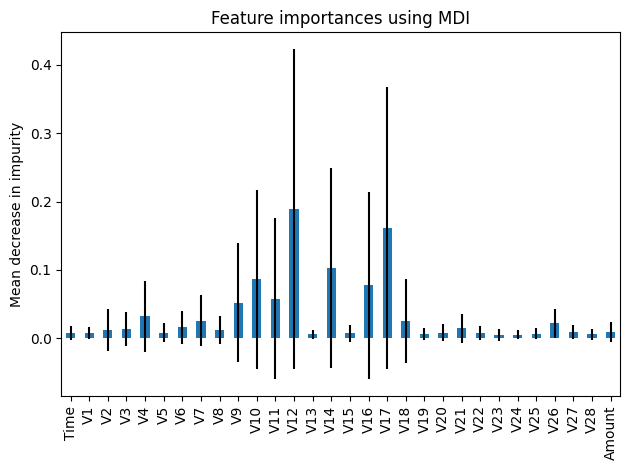

In [ ]:
forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
result = permutation_importance(
    rf_model, x_test, y_test, n_repeats=10, random_state=13, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

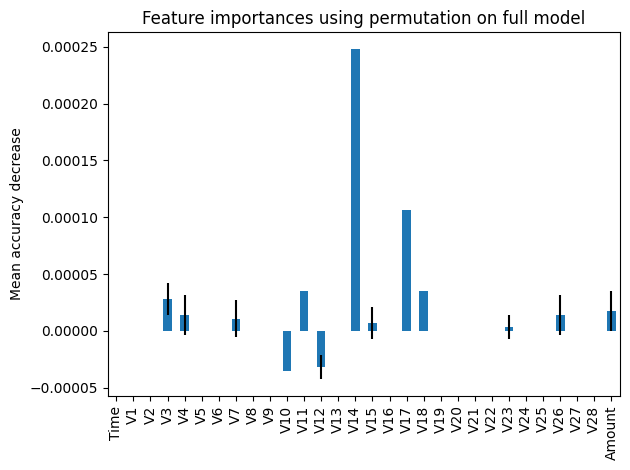

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
x_fraud = dataset_test.loc[dataset_test['Class'] == 1]
x_fraud = x_fraud.drop("Class", axis = 1)
x_fraud = x_fraud.to_numpy()

explainer_fraud = shap.TreeExplainer(rf_model, x_fraud)
shap_values_fraud = explainer(x_fraud)

In [ ]:
x_legit = dataset_test.loc[dataset_test['Class'] == 0]
x_legit = x_legit.drop("Class", axis = 1)
x_legit = x_legit[:452]
x_legit = x_legit.to_numpy()

explainer_legit = shap.TreeExplainer(rf_model, x_legit)
shap_values_legit = explainer(x_legit)

In [ ]:
explainer = shap.TreeExplainer(rf_model, x_test)
shap_values = explainer(x_test)

100%|===================| 56117/56394 [02:28<00:00]       

In [ ]:
shap_values.shape

(28197, 30, 2)

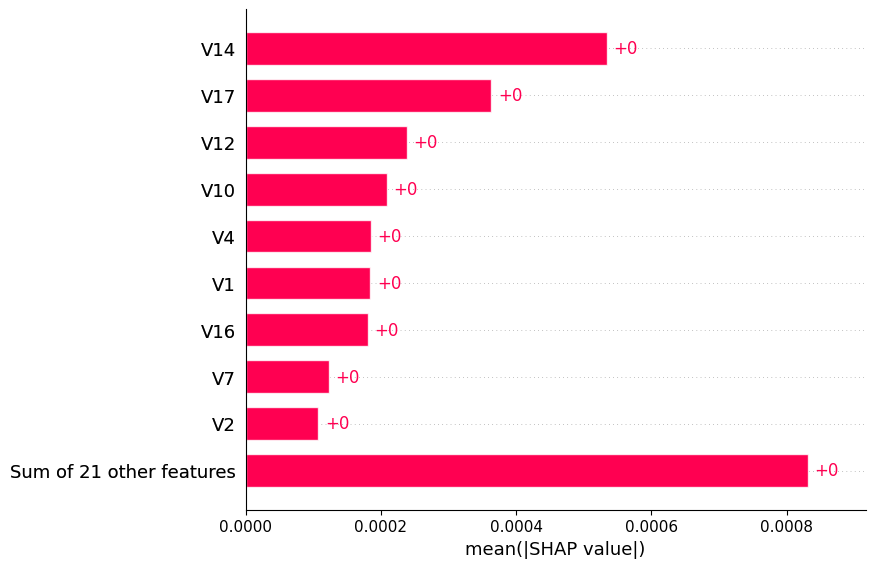

In [ ]:
shap.plots.bar(shap_values[:,:,1], order=shap.Explanation.argsort.flip)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


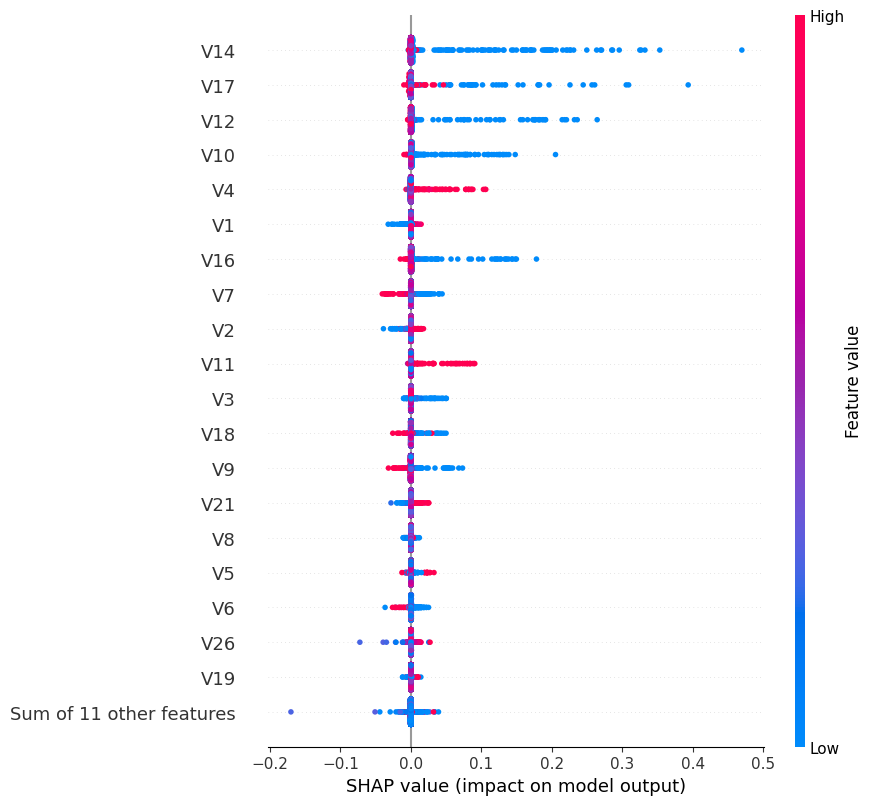

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 20)

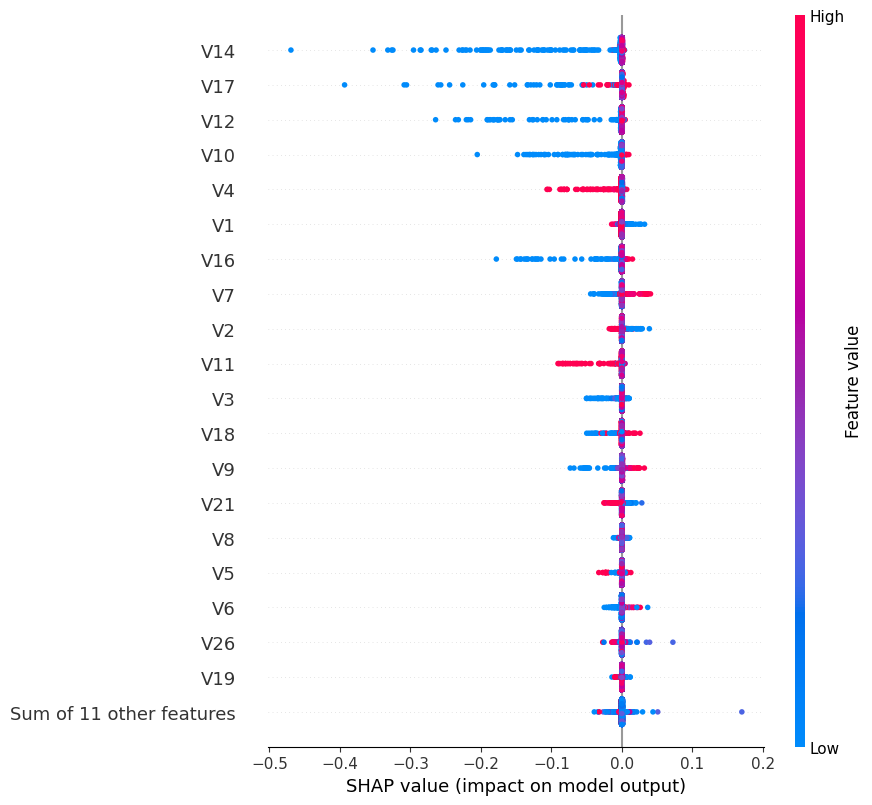

In [ ]:
shap.plots.beeswarm(shap_values[:,:,0], max_display = 20)

#### **Intervalos Influentes**

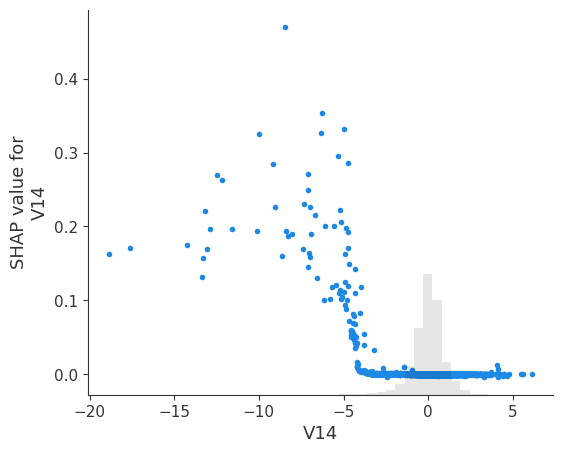

In [ ]:
shap.plots.scatter(shap_values[:,"V14", 1])

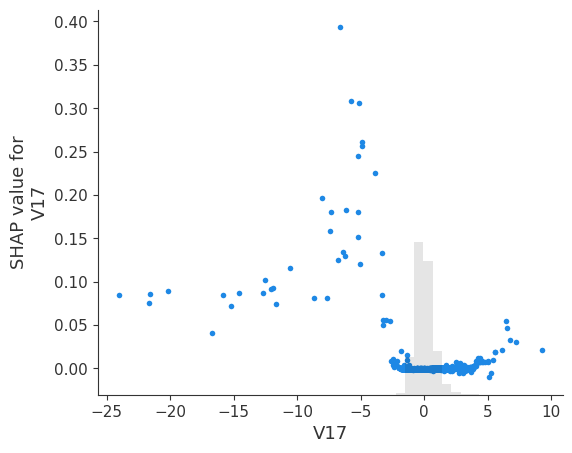

In [ ]:
shap.plots.scatter(shap_values[:,"V17", 1])

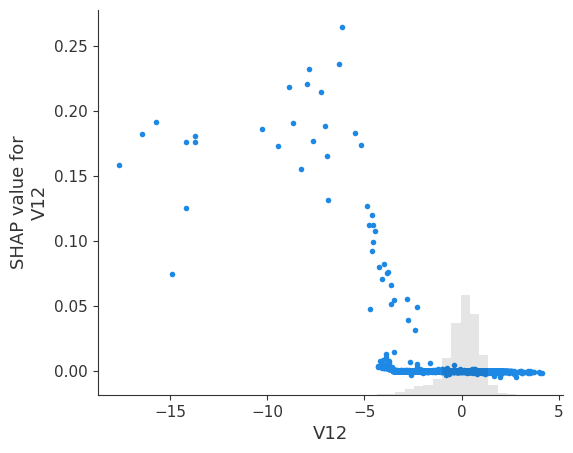

In [ ]:
shap.plots.scatter(shap_values[:,"V12", 1])

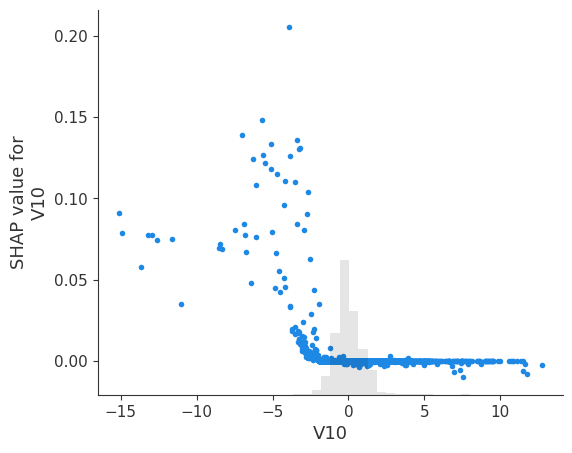

In [ ]:
shap.plots.scatter(shap_values[:,"V10", 1])

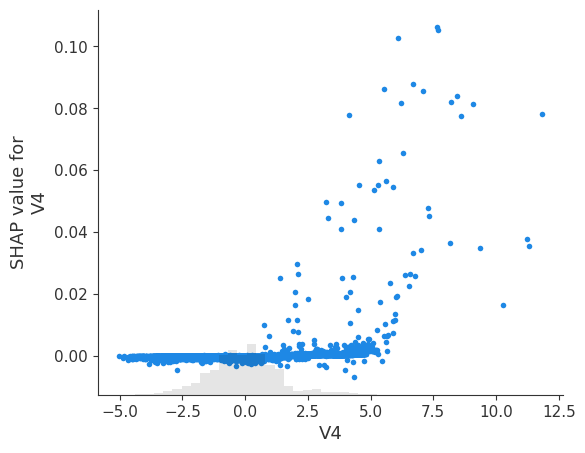

In [ ]:
shap.plots.scatter(shap_values[:,"V4", 1])

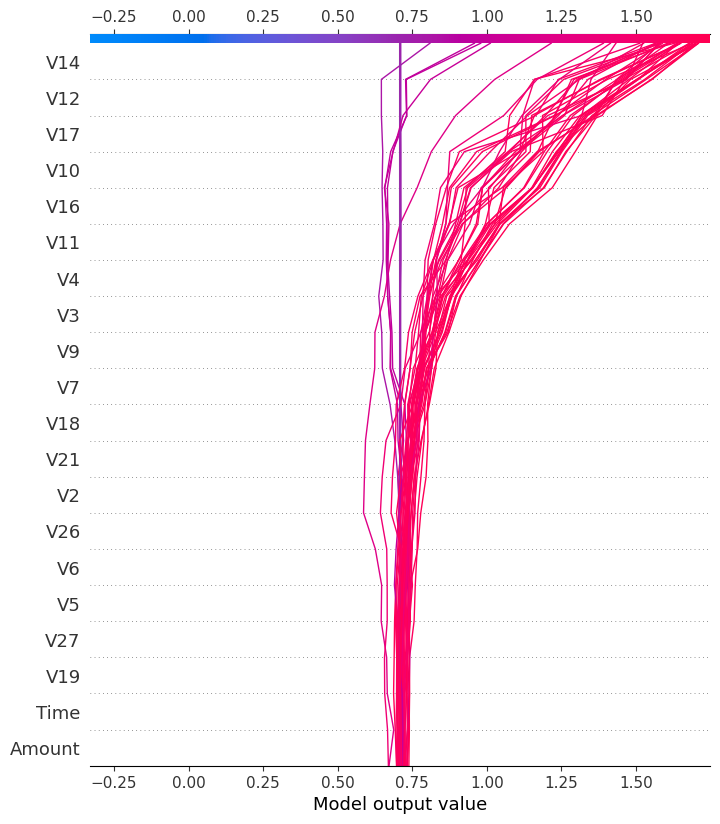

In [ ]:
shap.decision_plot(explainer_fraud.expected_value[1], shap_values_fraud.values[:50,:,1], dataset.columns[:-1])

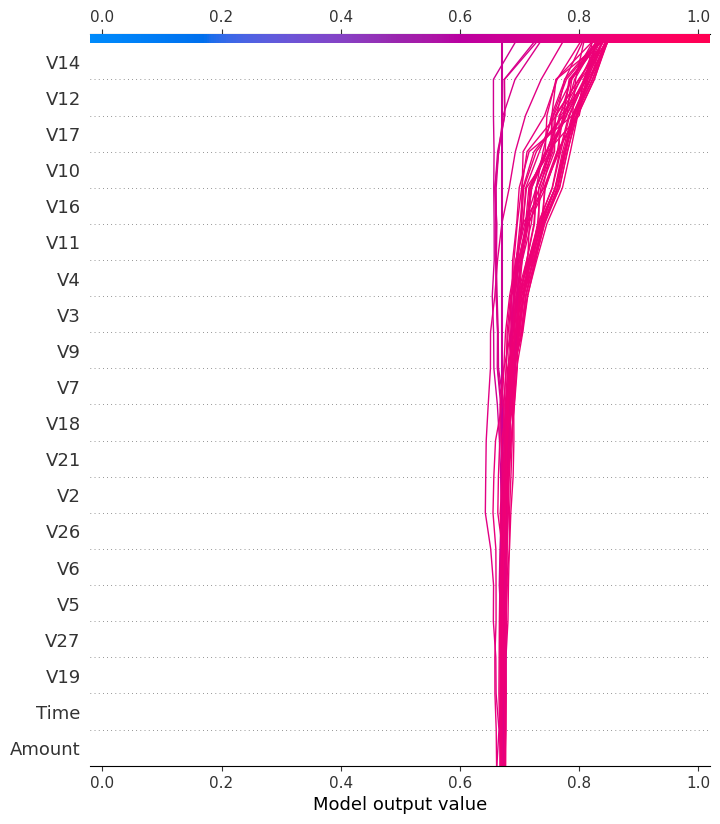

In [ ]:
shap.decision_plot(explainer_fraud.expected_value[1], shap_values_fraud.values[:50,:,1], dataset.columns[:-1],
                   link='logit')

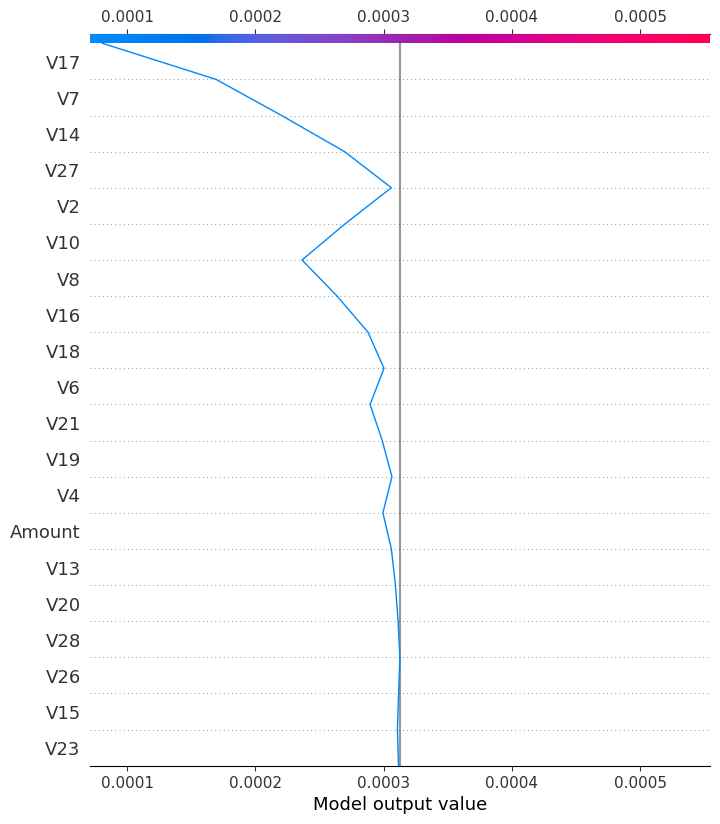

In [ ]:
shap.decision_plot(explainer_legit.expected_value[1], shap_values_legit.values[68:69,:,1], dataset.columns[:-1])

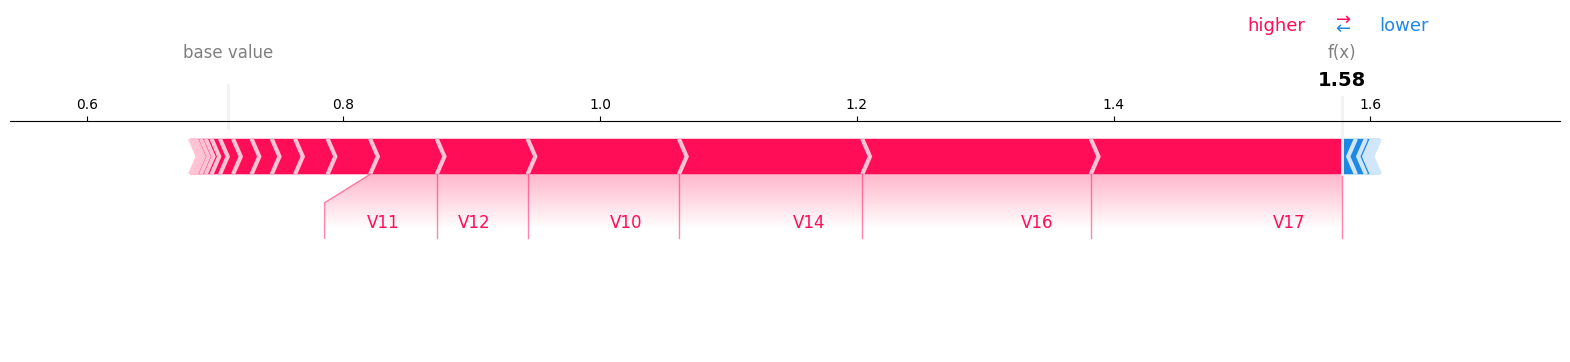

In [ ]:
shap.force_plot(explainer_fraud.expected_value[1], shap_values_fraud.values[:1,:,1], dataset.columns[:-1], matplotlib = True)

#### **Correlação de Pearlson**

<Axes: >

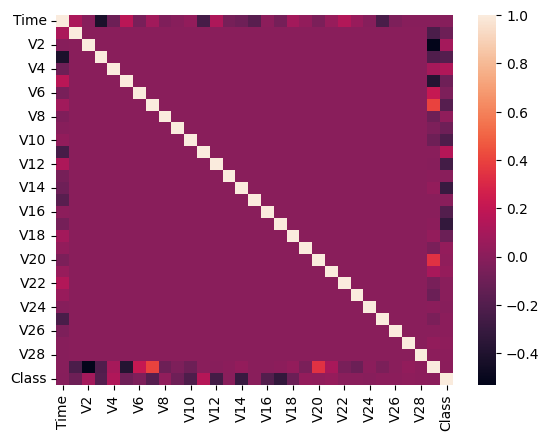

In [ ]:
sns.heatmap (dataset.corr(), annot=False)

#### **Correlação de Spearman**

<Axes: >

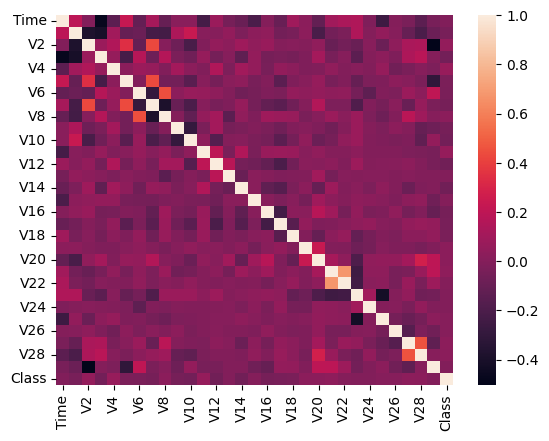

In [ ]:
sns.heatmap (dataset.corr('spearman'), annot=False)